# Prophet predictor
This notebook contains a timeseries predictor model built with the fbprophet library. 

## Training

In [1]:
import numpy as np
import pandas as pd

### Copy the data locally

In [2]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [3]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7fa2a361f2b0>)

In [4]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [5]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [6]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [7]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [8]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']
df = df[id_cols + cases_col + npi_cols]

In [9]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [10]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [11]:
df

,CountryName,RegionName,GeoID,Date,NewCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
0,Aruba,NaN,Aruba__nan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,NaN,Aruba__nan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,NaN,Aruba__nan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,NaN,Aruba__nan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,NaN,Aruba__nan,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91155,Zimbabwe,NaN,Zimbabwe__nan,2020-12-05,70.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
91156,Zimbabwe,NaN,Zimbabwe__nan,2020-12-06,101.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
91157,Zimbabwe,NaN,Zimbabwe__nan,2020-12-07,121.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
91158,Zimbabwe,NaN,Zimbabwe__nan,2020-12-08,73.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0


In [12]:
# For testing, restrict training data to that before a hypothetical predictor submission date
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-11-15")
test = df[df.Date > HYPOTHETICAL_SUBMISSION_DATE]
df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [13]:
# install prophet
#!sudo pip install fbprophet

In [14]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


<ipython-input-15-f57bc9781b6f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = to_datetime(df['Date'])
<ipython-input-15-f57bc9781b6f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['NewCases']


<AxesSubplot:title={'center':'avg daily new cases'}, xlabel='ds'>

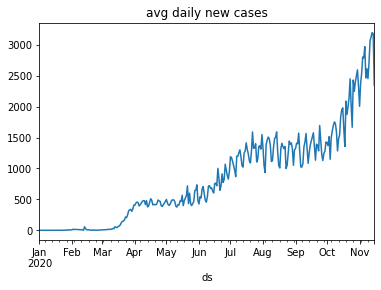

In [15]:
# evaluate prophet time series forecasting model on hold out dataset
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# prepare expected column names
df['ds'] = to_datetime(df['Date'])
df['y'] = df['NewCases']

df.index = df['ds']
df['NewCases'].resample('D').mean().plot(title='avg daily new cases')

In [16]:
# define the model
naive_model = Prophet()
# fit the model
naive_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
import datetime
from datetime import date
numdays = 21 # number of days to forecast for
base = date(2020,11,16)
future = [base + datetime.timedelta(days=x) for x in range(numdays)]

In [18]:
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])

# use the model to make a forecast
forecast = naive_model.predict(future)

In [19]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-16,2752.379501,-3506.449857,8224.538841,2752.379501,2752.379501,-80.836032,-80.836032,-80.836032,-80.836032,-80.836032,-80.836032,0.0,0.0,0.0,2671.543469
1,2020-11-17,2777.426323,-3165.874025,8542.919672,2777.426323,2777.426323,-11.024218,-11.024218,-11.024218,-11.024218,-11.024218,-11.024218,0.0,0.0,0.0,2766.402105
2,2020-11-18,2802.473145,-3041.713251,8704.573767,2801.932790,2802.648952,49.078602,49.078602,49.078602,49.078602,49.078602,49.078602,0.0,0.0,0.0,2851.551747
3,2020-11-19,2827.519967,-2748.347818,8720.247512,2825.666965,2829.051748,78.325582,78.325582,78.325582,78.325582,78.325582,78.325582,0.0,0.0,0.0,2905.845549
4,2020-11-20,2852.566789,-2768.858117,8735.793654,2847.562177,2857.092197,96.022476,96.022476,96.022476,96.022476,96.022476,96.022476,0.0,0.0,0.0,2948.589265
5,2020-11-21,2877.613611,-2914.477119,8637.468326,2868.728807,2886.413913,7.095883,7.095883,7.095883,7.095883,7.095883,7.095883,0.0,0.0,0.0,2884.709494
6,2020-11-22,2902.660433,-3023.564535,8607.384654,2890.080045,2916.034402,-138.662292,-138.662292,-138.662292,-138.662292,-138.662292,-138.662292,0.0,0.0,0.0,2763.998141
7,2020-11-23,2927.707255,-2978.891509,8710.484093,2911.569417,2945.450097,-80.836032,-80.836032,-80.836032,-80.836032,-80.836032,-80.836032,0.0,0.0,0.0,2846.871222
8,2020-11-24,2952.754077,-2841.727623,8723.972220,2931.438134,2975.843165,-11.024218,-11.024218,-11.024218,-11.024218,-11.024218,-11.024218,0.0,0.0,0.0,2941.729859
9,2020-11-25,2977.800899,-3136.835221,8765.481506,2951.997605,3007.684516,49.078602,49.078602,49.078602,49.078602,49.078602,49.078602,0.0,0.0,0.0,3026.879500


In [32]:
y_true_df = test[(np.datetime64("2020-12-06") >= test.Date)]
y_true_df[y_true_df['CountryName'] == 'Aruba']

,CountryName,RegionName,GeoID,Date,NewCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
320,Aruba,NaN,Aruba__nan,2020-11-16,6.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
321,Aruba,NaN,Aruba__nan,2020-11-17,8.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
322,Aruba,NaN,Aruba__nan,2020-11-18,9.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
323,Aruba,NaN,Aruba__nan,2020-11-19,8.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
324,Aruba,NaN,Aruba__nan,2020-11-20,5.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
325,Aruba,NaN,Aruba__nan,2020-11-21,26.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
326,Aruba,NaN,Aruba__nan,2020-11-22,7.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
327,Aruba,NaN,Aruba__nan,2020-11-23,6.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
328,Aruba,NaN,Aruba__nan,2020-11-24,14.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0
329,Aruba,NaN,Aruba__nan,2020-11-25,27.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0


Aruba MAE: 2988.419
Afghanistan MAE: 2809.229
Angola MAE: 2900.943
Albania MAE: 2281.038
Andorra MAE: 2946.752
United Arab Emirates MAE: 1760.752
Argentina MAE: 4264.724
Australia MAE: 2992.229
Austria MAE: 1803.715
Azerbaijan MAE: 733.878
Burundi MAE: 2999.705
Belgium MAE: 876.083
Benin MAE: 2992.800
Burkina Faso MAE: 2975.657
Bangladesh MAE: 849.895
Bulgaria MAE: 931.295
Bahrain MAE: 2849.181
Bahamas MAE: 2984.562
Bosnia and Herzegovina MAE: 1928.991
Belarus MAE: 1432.752
Belize MAE: 2864.372
Bermuda MAE: 2999.705
Bolivia MAE: 2892.657


ValueError: Found input variables with inconsistent numbers of samples: [588, 21]

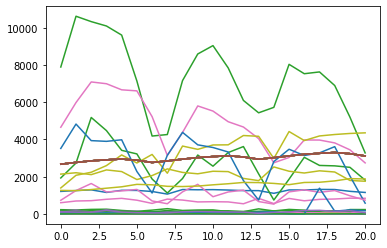

In [36]:
# calculate MAE between expected and predicted values for december
y_pred = forecast['yhat'].values

for country in y_true_df.CountryName.unique():
    y_true_df = test[(np.datetime64("2020-12-06") >= test.Date)]
    y_true= y_true_df[y_true_df['CountryName'] == country]['NewCases'].values
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{country} MAE: %.3f' % mae)
    # plot expected vs actual
    pyplot.plot(y_true, label='Actual')

    pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [35]:
y_true_df.CountryName.unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic',
       'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic',
       'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Spain', 'Estonia',
       'Ethiopia', 'Finland', 'Fiji', 'France', 'Faeroe Islands', 'Gabon',
       'United Kingdom', 'Georgia', 'Ghana', 'Guinea', 'Gambia', 'Greece',
       'Greenland', 'Guatemala', 'Guam', 'Guyana', 'Hong Ko

In [39]:
y_true_df[y_true_df['CountryName'] == 'Zambia']

,CountryName,RegionName,GeoID,Date,NewCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
90792,Zambia,NaN,Zambia__nan,2020-11-16,64.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90793,Zambia,NaN,Zambia__nan,2020-11-17,56.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90794,Zambia,NaN,Zambia__nan,2020-11-18,37.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90795,Zambia,NaN,Zambia__nan,2020-11-19,70.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90796,Zambia,NaN,Zambia__nan,2020-11-20,23.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90797,Zambia,NaN,Zambia__nan,2020-11-21,21.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90798,Zambia,NaN,Zambia__nan,2020-11-22,30.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90799,Zambia,NaN,Zambia__nan,2020-11-23,30.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90800,Zambia,NaN,Zambia__nan,2020-11-24,12.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
90801,Zambia,NaN,Zambia__nan,2020-11-25,69.0,1.0,2.0,1.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0
